# Task 3

This notebook is part of Milestone 3, Question 3. You can work on this notebook on your laptop to develop your machine learning model using all the learnings from the previous courses. At the end of this notebook, when you are ready to train the model, you will need to obtain the hyperparameters from the hyperparameter tuning job that you will run in Milestone 3 Question 4 (i.e., the notebook named `Milestone3-Task4.ipynb`).

PS: To speed up the process, you can test the model without the hyperparameters first. Once other team members obtain the hyperparameters, you can retrain the model using those hyperparameters and test it again.

In [3]:
# I asked them to use their laptop so they already got all these packages from previous courses.
# %pip install joblib scikit-learn matplotlib s3fs

# Imports

In [16]:
import os 

import numpy as np
import pandas as pd
from joblib import dump, load
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 16, 'axes.labelweight': 'bold', 'figure.figsize': (8,6)})
## add any other additional packages that you need. You are free to use any packages for vizualization.

## Part 1:

Recall as a final goal of this project. We want to build and deploy ensemble machine learning models in the cloud, where features are outputs of different climate models and the target is the actual rainfall observation. In this milestone, you'll actually build these ensemble machine learning models in the cloud.  

**Your tasks:**

1. Read the data CSV from your s3 bucket. 
2. Drop rows with nans. 
3. Split the data into train (80%) and test (20%) portions with `random_state=123`. 
4. Carry out EDA of your choice on the train split. 
5. Train ensemble machine learning model using `RandomForestRegressor` and evaluate with metric of your choice (e.g., `RMSE`) by considering `Observed` as the target column. 
6. Discuss your results. Are you getting better results with ensemble models compared to the individual climate models? 

> Recall that individual columns in the data are predictions of different climate models. 

In [4]:
## Remember by default it looks for credentials in home directory. 
os.environ["AWS_SHARED_CREDENTIALS_FILE"] = "/srv/keys/credentials"

In [63]:
## Remember by default it looks for credentials in home directory. 
## Make sure your updated credentials are in home directory
## or pass credentials explicitly and pass as storage_options=aws_credentials (not a good idea)
# aws_credentials = {"key": "","secret": "","token":""}
# replace with s3 path to your data
df = pd.read_csv("s3://mds-s3-19-jonah/output/ml_data_SYD.csv", index_col=0, parse_dates=True)
df.dropna(inplace=True)

In [65]:
# initial eda
df.describe()

,ACCESS-CM2,ACCESS-ESM1-5,AWI-ESM-1-1-LR,BCC-CSM2-MR,BCC-ESM1,CMCC-CM2-HR4,CMCC-CM2-SR5,CMCC-ESM2,CanESM5,EC-Earth3-Veg-LR,...,MPI-ESM-1-2-HAM,MPI-ESM1-2-HR,MPI-ESM1-2-LR,MRI-ESM2-0,NESM3,NorESM2-LM,NorESM2-MM,SAM0-UNICON,TaiESM1,observed_rainfall
count,45989.000000,45989.000000,4.598900e+04,4.598900e+04,4.598900e+04,45989.000000,4.598900e+04,4.598900e+04,45989.000000,4.598900e+04,...,4.598900e+04,4.598900e+04,4.598900e+04,4.598900e+04,4.598900e+04,45989.000000,45989.000000,4.598900e+04,4.598900e+04,45989.000000
mean,2.431806,2.912110,3.684362e+00,2.214373e+00,2.766260e+00,3.094129,3.592182e+00,3.498402e+00,2.906303,2.559391e+00,...,3.200653e+00,1.306521e+00,2.054750e+00,1.522577e+00,1.740391e+00,2.466659,2.874905,3.377089e+00,3.439387e+00,2.746271
std,6.805486,6.950376,7.215672e+00,6.519264e+00,6.046349e+00,6.428187,7.380218e+00,7.081748e+00,6.952669,5.745700e+00,...,6.925382e+00,4.883301e+00,5.374831e+00,4.950264e+00,4.873195e+00,5.840171,7.042097,7.917762e+00,7.578074e+00,8.188742
min,0.000000,0.000000,9.161142e-14,4.211430e-24,1.091904e-24,0.000000,-4.503054e-17,-3.186177e-19,0.000000,-9.934637e-19,...,3.315622e-13,1.088608e-13,9.155419e-14,9.479186e-33,1.426891e-13,0.000000,0.000000,-3.604673e-17,-2.148475e-14,0.000000
25%,0.053938,0.021419,2.869125e-02,5.258618e-04,2.486227e-03,0.138606,9.038497e-02,9.034570e-02,0.022485,1.220703e-02,...,1.181848e-04,1.270086e-13,1.353594e-13,5.553587e-05,1.864229e-13,0.005702,0.010022,3.691410e-02,4.943192e-02,0.008082
50%,0.191670,0.493374,5.882084e-01,9.767620e-02,2.956025e-01,0.639971,8.391182e-01,8.362362e-01,0.341963,4.316330e-01,...,2.072208e-01,1.599267e-03,1.153962e-01,3.210703e-02,5.181828e-02,0.171170,0.255601,6.518721e-01,6.720489e-01,0.163195
75%,1.432721,2.393983,3.587619e+00,1.336874e+00,2.503836e+00,3.198174,3.744974e+00,3.639139e+00,2.565126,2.296972e+00,...,2.699626e+00,3.534582e-01,1.192457e+00,6.729213e-01,7.935492e-01,1.841958,2.466907,3.270405e+00,3.236312e+00,1.633048
max,149.967634,157.605713,8.946575e+01,1.344652e+02,8.713472e+01,124.952390,1.401478e+02,1.375916e+02,135.569753,1.342262e+02,...,9.306766e+01,1.095008e+02,8.005998e+01,1.051568e+02,8.045783e+01,114.898109,163.164524,1.549718e+02,1.673562e+02,256.455080


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45989 entries, 1889-01-01 to 2014-12-31
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ACCESS-CM2         45989 non-null  float64
 1   ACCESS-ESM1-5      45989 non-null  float64
 2   AWI-ESM-1-1-LR     45989 non-null  float64
 3   BCC-CSM2-MR        45989 non-null  float64
 4   BCC-ESM1           45989 non-null  float64
 5   CMCC-CM2-HR4       45989 non-null  float64
 6   CMCC-CM2-SR5       45989 non-null  float64
 7   CMCC-ESM2          45989 non-null  float64
 8   CanESM5            45989 non-null  float64
 9   EC-Earth3-Veg-LR   45989 non-null  float64
 10  FGOALS-g3          45989 non-null  float64
 11  GFDL-CM4           45989 non-null  float64
 12  INM-CM4-8          45989 non-null  float64
 13  INM-CM5-0          45989 non-null  float64
 14  KIOST-ESM          45989 non-null  float64
 15  MIROC6             45989 non-null  float64
 16  MPI-E

In [36]:
# split into test/train 
train_df,test_df = train_test_split(df, test_size= 0.2, random_state=525)

X_train, y_train = train_df.drop(columns=['observed_rainfall']), train_df['observed_rainfall']
X_test, y_test = test_df.drop(columns=['observed_rainfall']), test_df['observed_rainfall']

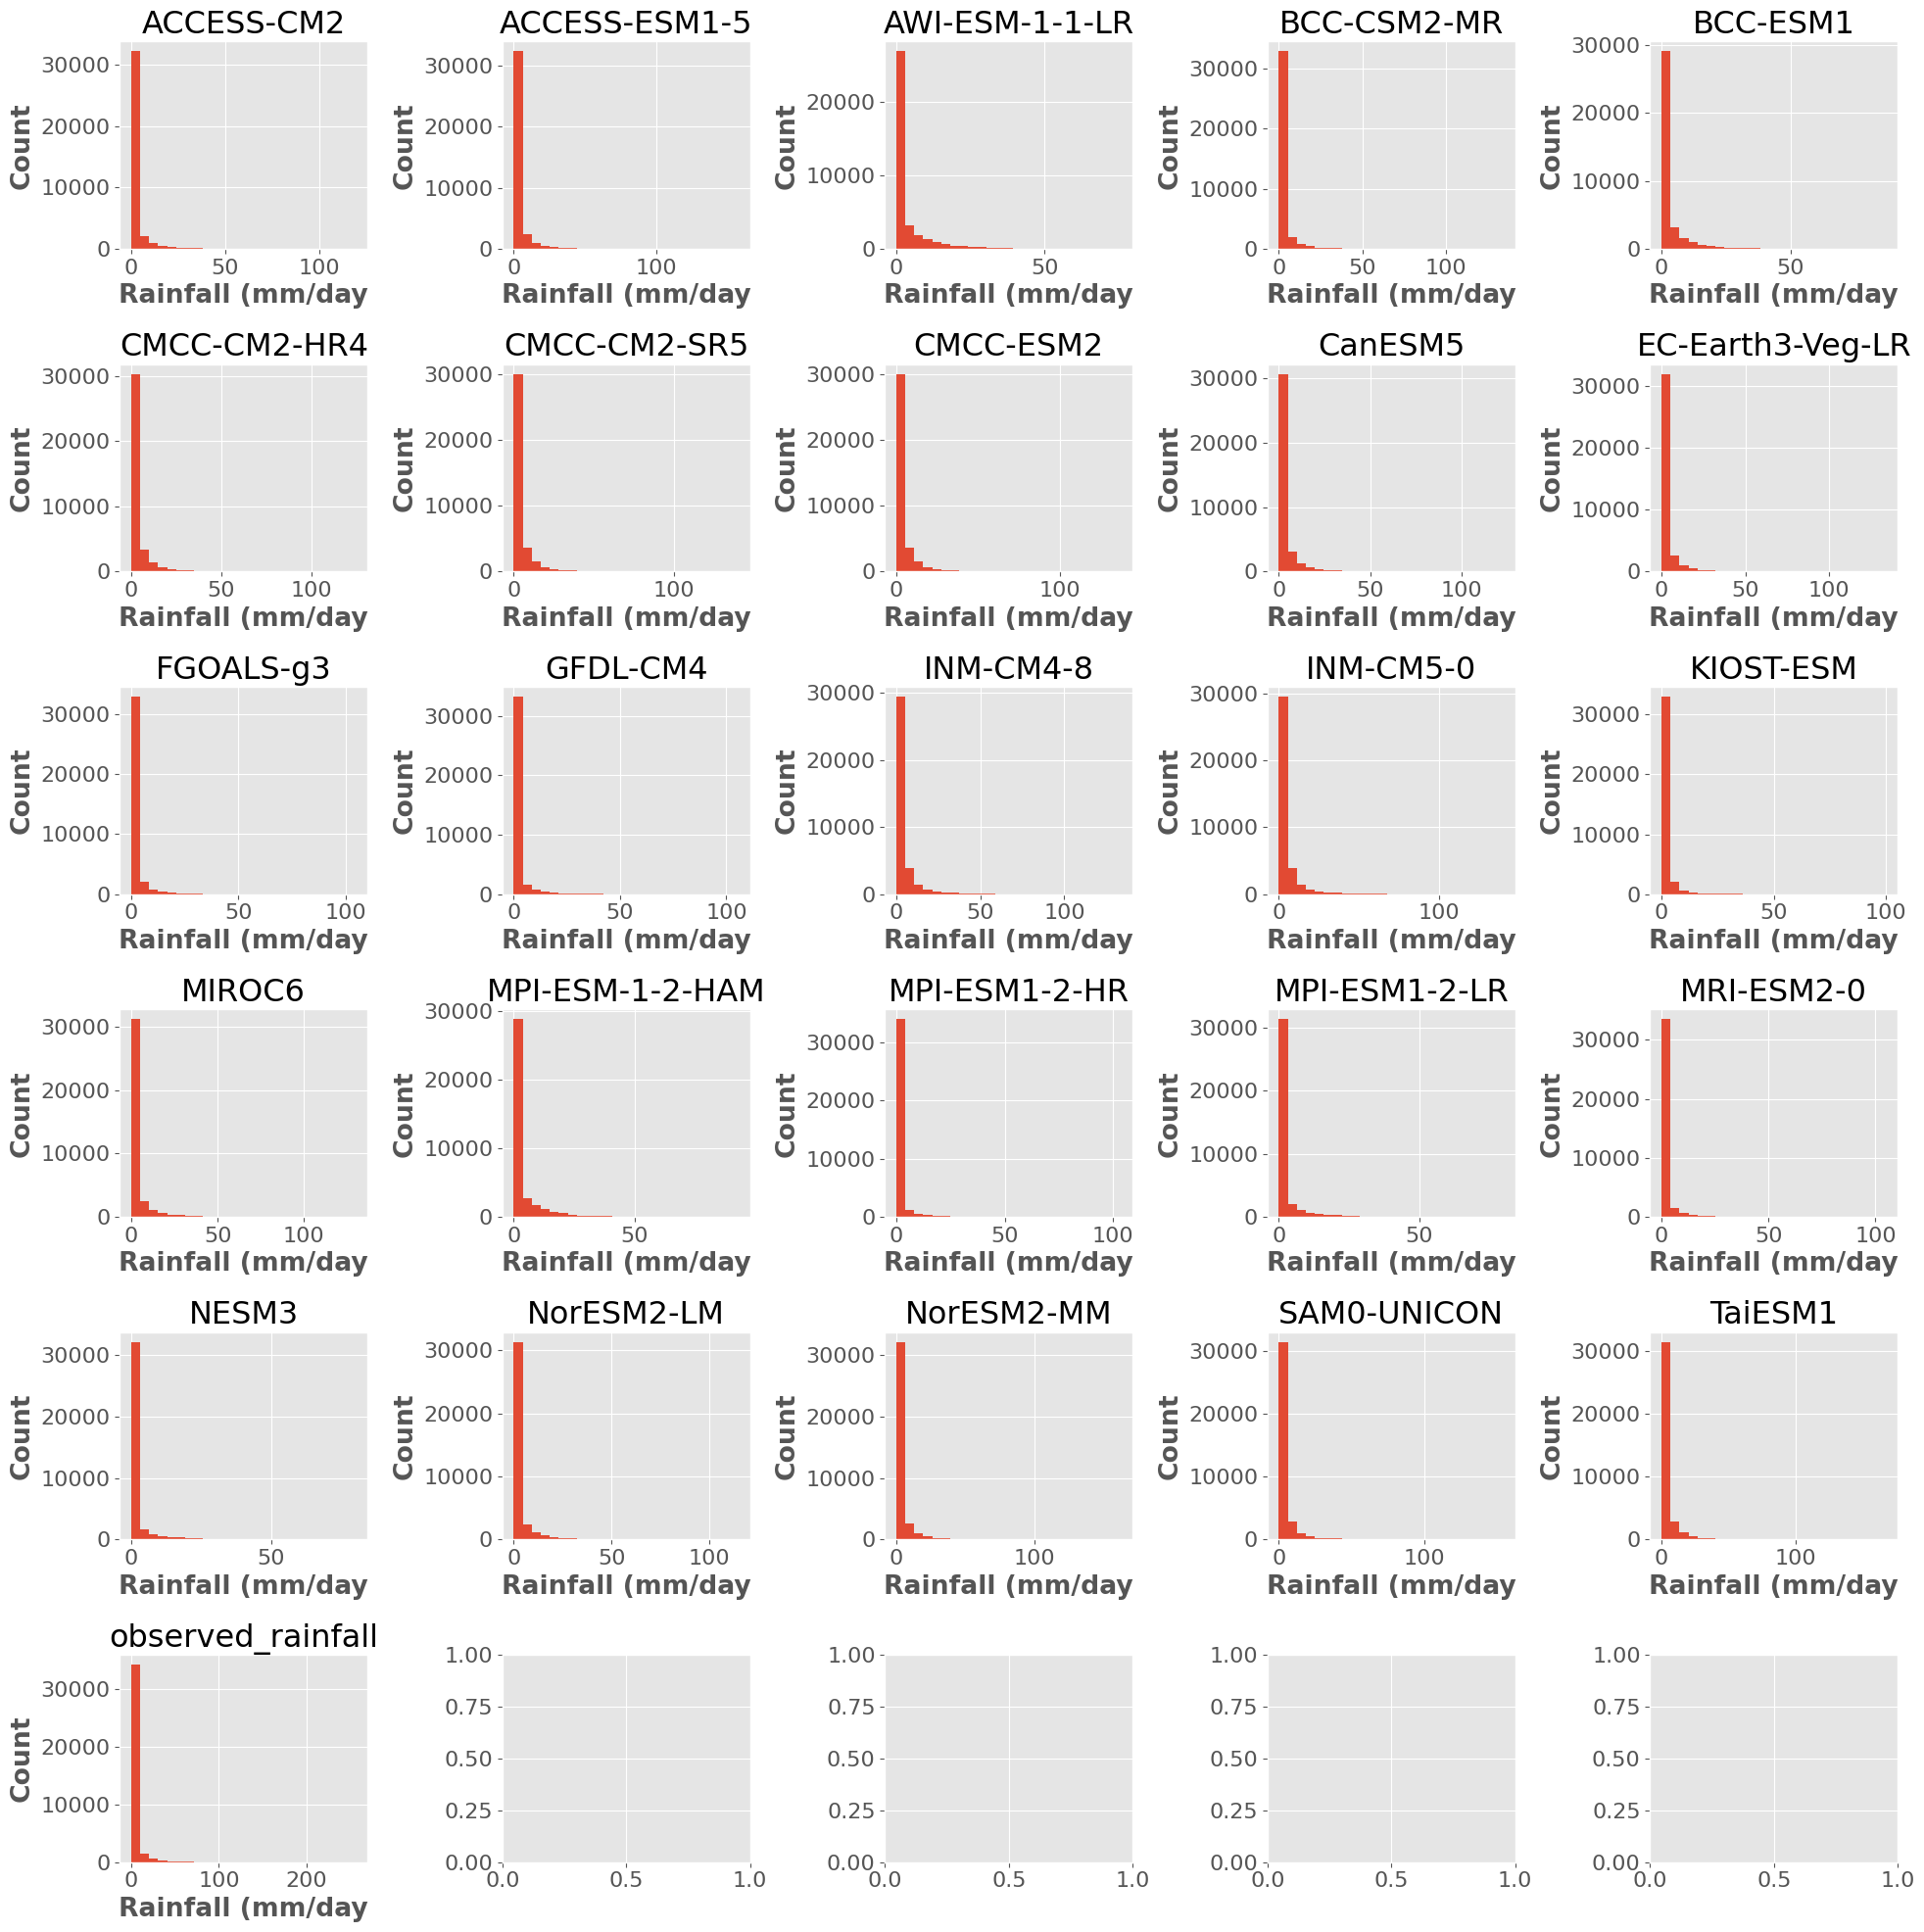

In [70]:
fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(20, 20))
axes = axes.ravel()

for i, model in enumerate(train_df.columns):
    train_df[model].hist(ax=axes[i], bins=25)
    axes[i].set_title(model)
    axes[i].set_xlabel('Rainfall (mm/day')
    axes[i].set_ylabel('Count')
    
fig.tight_layout()
plt.show()


In [33]:
# fit baseline model
random_forrest = RandomForestRegressor(random_state=525)

random_forrest.fit(X_train, y_train)

RandomForestRegressor(random_state=525)

In [47]:
print(f"Train RMSE: {mean_squared_error(y_train, random_forrest.predict(X_train), squared=False):.2f}")
print(f" Test RMSE: {mean_squared_error(y_test, random_forrest.predict(X_test), squared=False):.2f}")

Train RMSE: 3.21
 Test RMSE: 7.67


In [55]:
per_model_rmse = (
    pd.DataFrame(
        {
            "Model": X_train.columns,
            "Train_RMSE": [
                mean_squared_error(y_train, X_train[model], squared=False)
                for model in X_train.columns
            ],
            "Test_RMSE": [
                mean_squared_error(y_test, X_test[model], squared=False)
                for model in X_train.columns
            ],
        }
    )
    .set_index("Model")
    .sort_values("Test_RMSE")
)

per_model_rmse

,Train_RMSE,Test_RMSE
Model,,
KIOST-ESM,9.452746,8.547332
FGOALS-g3,9.556841,8.564811
NESM3,9.654353,8.835577
MPI-ESM1-2-HR,9.754524,8.889865
MRI-ESM2-0,9.837370,8.983434
MPI-ESM1-2-LR,9.975492,9.066494
EC-Earth3-Veg-LR,10.217556,9.159423
NorESM2-LM,10.190669,9.298216
BCC-ESM1,10.382069,9.341200


First looking at the default random forest model, the gap in train/test RMSE (3.21, 7.67)  indicates the model is overfit. When Comparing the results of the ensemble/individual models, we can see that although the gap between the train/test RMSE's are much smaller, the best test RMSE of 8.5 is still larger than the RMSE of the ensemble model. Once we use the tuned hyperparameters with the ensemble model, we can see the gap between the train/test RMSE (8.21, 7.42) indicating our model is no longer overfit and we have also slightly increased our test RMSE. 

## Part 2:

### Preparation for deploying model next week

***NOTE: Complete Question 4 (`Milestone3-task4.ipynb`) from the milestone 3 before coming here***

We’ve found the best hyperparameter settings with MLlib (from the Question 4 from milestone3), here we then use the same hyperparameters to train a scikit-learn model. 

In [58]:
# Just replace ___ with the numbers you found from Milestone3-task4.ipynb
model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=525)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, random_state=525)

In [59]:
print(f"Train RMSE: {mean_squared_error(y_train, model.predict(X_train), squared=False):.2f}")
print(f" Test RMSE: {mean_squared_error(y_test, model.predict(X_test), squared=False):.2f}")

Train RMSE: 8.21
 Test RMSE: 7.41


In [60]:
# ready to deploy
# where this model is saved? Understand the concept of relative path.
dump(model, "model.joblib")

['model.joblib']

***Upload model.joblib to s3 under output folder. You choose how you want to upload it (using CLI, SDK, or web console).*** Web console is also completely fine as it is a small file.